In [2]:
import sys
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# uncomment the following line if 'imutils' is not installed in your python kernel
# !{sys.executable} -m pip install imutils
import imutils
from imutils import paths


import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Activation, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.losses import categorical_crossentropy, binary_crossentropy
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.regularizers import l2
from keras import regularizers
from keras.callbacks import ModelCheckpoint


import cv2
import time
import random
import shutil


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Let's have a look at our Data

In [3]:
# Path to the folders containing images

data_path = 'data'
mask_path = 'data/with_mask/'
nomask_path = 'data/without_mask/'
test_path = 'data/test/'



In [4]:
# function to show images from the input path
def view(path):
    images = list()
    for img in random.sample(os.listdir(path),9):
        images.append(img)
    i = 0
    fig,ax = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
    for row in range(3):
        for col in range(3):
            ax[row,col].imshow(cv2.imread(os.path.join(path,images[i])))
            i+=1

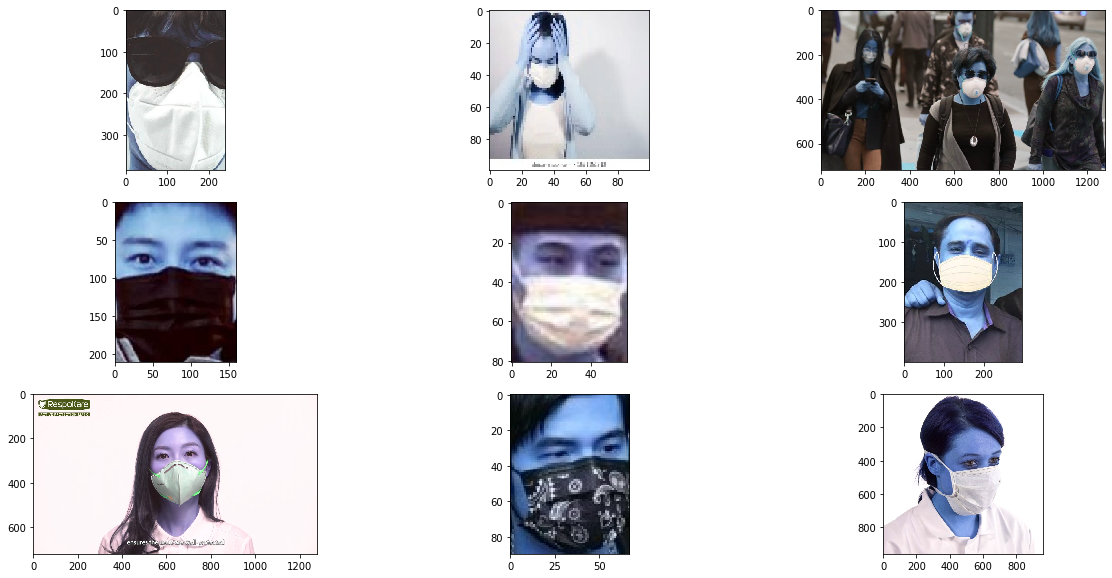

In [5]:
# sample images of people wearing masks
view(mask_path)

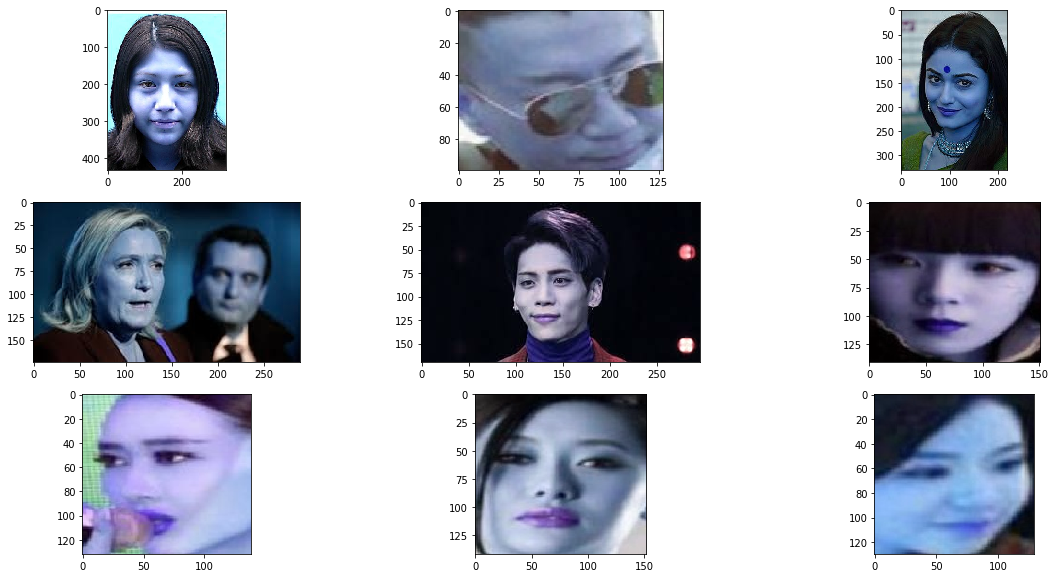

In [6]:
#sample images of people NOT wearning masks
view(nomask_path)

# Splitting of Data

- Mask : 755
- No Mask : 753
<br><br>
Since the images are already augmented, I have used sklearn to split the dataset into training and test set. 10% of the images are taken as the test set and the rest are further distributed into training and validation set.

In [7]:
# Initializing labels for masked and non-masked image output
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

# Storing the size of the input images and the path to feature and label for the model (via opencv).
img_size=224
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 224x224, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]
Exception: OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Exception: OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Exception: OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Exception: OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Exception: OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Exception: OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: erro

In [8]:
# Normalization of the data is done and converted into numpy arrays
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)


# Using 'utils' from keras, the target is converted into one-hot encoder for binary output
from keras.utils import np_utils

target=np_utils.to_categorical(target)

np.save('data',data)
np.save('target',target)

# Preparation of Data Pipelining

In [9]:
batch_size = 32


In [10]:
# Splitting of training data into training and test set
# 10% of the images are sent for testing.

from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)



# Building the Model

- In the next step, we build our Sequential CNN model with various layers such as Conv2D, MaxPooling2D, Flatten, Dropout and Dense. 
- In the last Dense layer, we use the ‘**softmax**’ function to output a vector that gives the probability of each of the two classes.
- Regularization is done to prevent overfitting of the data. It is neccessary since our dataset in not very large and just around 5000 images in total.

In [11]:
model=Sequential()

model.add(Conv2D(224,(3,3), activation ='relu', input_shape=data.shape[1:], kernel_regularizer=regularizers.l2(0.003)))
model.add(MaxPooling2D() )

model.add(Conv2D(100,(3,3), activation ='relu', kernel_regularizer=regularizers.l2(0.003)))
model.add(MaxPooling2D() )

model.add(Conv2D(100,(3,3), activation ='relu', kernel_regularizer=regularizers.l2(0.003)))
model.add(MaxPooling2D() )

model.add(Conv2D(50,(3,3), activation ='relu', kernel_regularizer=regularizers.l2(0.003)))
model.add(MaxPooling2D() )

model.add(Conv2D(30,(3,3), activation ='relu', kernel_regularizer=regularizers.l2(0.003)))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(90, activation ='relu'))
model.add(Dense(30,  activation = 'relu'))
model.add(Dense(2, activation ='sigmoid'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 224)     2240      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 224)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 100)     201700    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 100)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 100)       90100     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 100)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 50)       

In [12]:
# Optimization of the model is done via Adam optimizer
# Loss is measures in the form of Binary Categorical Cross Entropy as our output contains 2 classes, with_mask and without_mask

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
#Model Checkpoint to save the model after training, so that it can be re-used while detecting faces


# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/Face Mask Detector/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = ModelCheckpoint(
    filepath = checkpoint_path,
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Training of the Model is done
history=model.fit(train_data, train_target, epochs=50, batch_size = batch_size, validation_split=0.15)

Train on 1153 samples, validate on 204 samples
Epoch 1/50
1153/1153 [==============================] - 23s 20ms/step - loss: 1.1842 - accuracy: 0.4970 - val_loss: 0.8504 - val_accuracy: 0.4951
Epoch 2/50
1153/1153 [==============================] - 16s 14ms/step - loss: 0.7541 - accuracy: 0.6088 - val_loss: 0.6171 - val_accuracy: 0.7819
Epoch 3/50
1153/1153 [==============================] - 17s 14ms/step - loss: 0.4885 - accuracy: 0.8135 - val_loss: 0.4394 - val_accuracy: 0.8505
Epoch 4/50
1153/1153 [==============================] - 16s 14ms/step - loss: 0.4049 - accuracy: 0.8474 - val_loss: 0.3001 - val_accuracy: 0.9265
Epoch 5/50
1153/1153 [==============================] - 16s 14ms/step - loss: 0.3133 - accuracy: 0.9024 - val_loss: 0.2611 - val_accuracy: 0.9363
Epoch 6/50
1153/1153 [==============================] - 16s 14ms/step - loss: 0.2508 - accuracy: 0.9302 - val_loss: 0.2222 - val_accuracy: 0.9583
Epoch 7/50
1153/1153 [==============================] - 16s 14ms/step - loss:

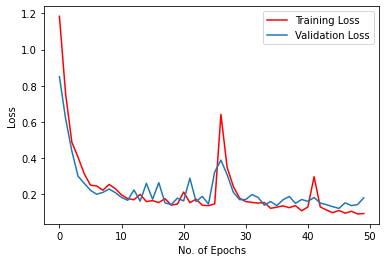

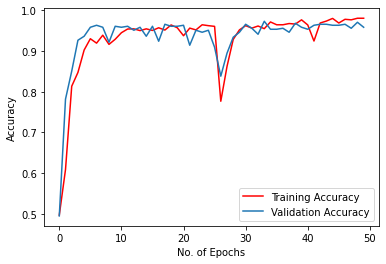

In [14]:
plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'],'r',label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
print(model.evaluate(test_data,test_target))


151/151 [==============================] - 2s 13ms/step
[0.12433266644643633, 0.9635761380195618]


In [16]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Now, look at the resulting checkpoints and choose the latest one:

In [18]:
model.save('/content/drive/My Drive/Colab Notebooks/Face Mask Detector/model.h5') 

In [1]:
# Importing the saved model from the IPython notebook
# model = load_model('/content/drive/My Drive/Colab Notebooks/Face Mask Detector/train_model.h5')


# Importing the Face Classifier XML file containing all features of the face
face_classifier=cv2.CascadeClassifier('/content/drive/My Drive/Colab Notebooks/Face Mask Detector/haarcascade_frontalface_default.xml')


# To open a video via link to be inserted in the () of VideoCapture()
# To open the web cam connected to your laptop/PC, write '0' (without quotes) in the () of VideoCapture()
src_cap = cv2.VideoCapture(0)


labels_dict = {
        0 : 'MASK ON',
        1 : 'NO MASK!'
    }

colorMap = {
        0 : (0,255,0),
        1 : (0,0,255)
    }


while(True):

    _, img = src_cap.read()

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # detect MultiScale / faces
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)  

    # Draw rectangles around each face
    for (x, y, w, h) in faces:
    
        #Save just the rectangle faces in SubRecFaces
        face_img = gray[y:y+w, x:x+w]

        resized = cv2.resize(face_img, (224,224))
        normalized = resized/255.0
        reshaped = np.reshape(normalized, (1,224,224,1))
        result = model.predict(reshaped)
        print(result)

        label = np.argmax(result, axis=1)[0]
      
        cv2.rectangle(img, (x,y), (x+w,y+h), colorMap[label],2)
        cv2.rectangle(img, (x,y-40), (x+w,y), colorMap[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
        
        
    # Show the image
    cv2.imshow('LIVE DETECTION', img)
    key = cv2.waitKey(1)  
    
    # if Esc key (27) is press then break out of the loop
    if(key==27):
        break
        
# Stop video
src_cap.release()

# Close all started windows
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined